# Demo for Data preprocessing

This notebook shows how the datasets were preprocessed(current notebook is for hourly data). It should be noted that the pre processing was done on each station for each frequency separately. After that point, the stations were combined into one dataframe for each of the three frequencies. 

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from darts import TimeSeries
from darts.models import NLinearModel
from darts.utils.missing_values import extract_subseries
from darts.dataprocessing.transformers.scaler import Scaler
from darts.metrics.metrics import mae, mse, mape
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import warnings
warnings.filterwarnings('ignore')
data_taiao = 'C:/Users/sidhant/Desktop/Dissertation/taiao_data'

# ICAO id of Wellington Airport
station_icao = 'NZAPA'

# WMO id of Wellington Airport
station_wmo = '93245'

### Selecting Target

In [2]:
# Modeling the 1h max temperature for a simple demo
target = 'WindSpd_01HrAvg'

Combining all the observed data and converting kelvin to celcius

In [3]:
file_paths = glob.glob(f'{data_taiao}/1minobs/{station_icao}/**/*202*.csv', recursive=True)
obs_csv = pd.concat([pd.read_csv(file, index_col='time', parse_dates=True)
                     for file in file_paths]).sort_index()
# Convert Celsius to Kelvin for all relevant temperature columns
obs_csv['AirTemp_01HrMax'] = obs_csv['AirTemp_01HrMax'] + 273.15
obs_csv['AirTemp_01HrMin'] = obs_csv['AirTemp_01HrMin'] + 273.15
obs_csv['AirTemp_01MnAvg'] = obs_csv['AirTemp_01MnAvg'] + 273.15
obs_csv['DewTemp_01MnAvg'] = obs_csv['DewTemp_01MnAvg'] + 273.15

### Dropping duplicate timestamps in observed dataset.

In [4]:
obs_csv = obs_csv.reset_index().sort_values(['time']).drop_duplicates(subset='time', keep='last').set_index('time')

# Combining the three NWP datasets for all stations

Null Values are being dropped

## WRF data

In [6]:
file_paths = glob.glob(f'{data_taiao}/nwp/ARWECMWFcld_single_nz4km/{station_wmo}/*202*.nc')
wrf_data = xr.open_mfdataset([file for file in file_paths],
                             engine='netcdf4',
                             concat_dim='run',
                             combine='nested',).dropna(dim='run', how='all')

## ECMWF Ensemble Data

In [7]:
file_paths_ensemble = glob.glob(f'{data_taiao}/nwp/ECMWF_ensemble_global/{station_wmo}/*202*.nc')
ecmwf_ensemble_data = xr.open_mfdataset([file for file in file_paths_ensemble],
                             engine='netcdf4',
                             concat_dim='run',
                             combine='nested',).dropna(dim='run', how='all')


## ECMWF single data

In [8]:
file_paths_single = glob.glob(f'{data_taiao}/nwp/ECMWF_single_global/{station_wmo}/*202*.nc')
ecmwf_single_data = xr.open_mfdataset([file for file in file_paths_single],
                             engine='netcdf4',
                             concat_dim='run',
                             combine='nested',).dropna(dim='run', how='all')


### Define the Covariates

Using only the selected covariates from PDP, ALE and Random forest ranking

Features selected in WRF

In [9]:
future_covariates_wrf = ['wspk10m', 'uuu30m', 'vvv10m', 'lapprs900hPa', 'uuu10m', 'wspk115m',  'vvv850hPa', 'wspk850hPa', 'mgust', 'vvv30m', 'swdown', 'uuu500m']

Features selected in ECMWF Ensemble

In [10]:
future_covariates_ecmwf_ensemble = ['v100m','tdwpt', 'f10m', 'g10m', 'gust10_inst', 'f100m','tmax', 'u100m', 'u10m', 'v10m']

Features selected in ECMWF SIngle

In [11]:
future_covariates_ecmwf_single = ['u100m', 'f100m', 'rh', 'ws850p', 'g10m', 'u10m', 'u925p', 'u850p', 'f10m', 'v925p']


Features Selected in 1 min obs

In [12]:
past_covariates = [
    'WindRun_01HrAcc', 'Data_Time_Day__', 'Data_Time_Hour_', 
    'Data_Time_Month', 'Data_Time_Year_', 'Stn_Numeric_ID_'
]

### Select only the past covariates in the Observed data(csv one)

In [13]:
obs_selected = obs_csv[[target] + past_covariates].reset_index().sort_values(['time']).drop_duplicates(subset='time', keep='last').set_index('time')
obs_selected.shape

(2062780, 7)

## Merge obs and NWP data - hourly

### Convert nwp dataset to data frame

#### Convert WRF dataset to data frame

In [15]:
# Add the valid_time of the NWP forecast, to join with the observation time
wrf_df = (wrf_data.to_dataframe().reset_index()
          .assign(valid_time = lambda x : x.run + x.prognosis_period).set_index('valid_time'))
wrf_df = wrf_df.reset_index().sort_values(['valid_time']).drop_duplicates(subset='valid_time', keep='last').set_index('valid_time')
wrf_df.shape

(39889, 96)

#### Convert ecmwf_ensemble dataset to data frame

In [16]:
# Add the valid_time of the NWP forecast, to join with the observation time
ecmwf_ensemble_data_df = (ecmwf_ensemble_data.to_dataframe().reset_index()
          .assign(valid_time = lambda x : x.run + x.prognosis_period).set_index('valid_time'))
ecmwf_ensemble_data_df = ecmwf_ensemble_data_df.reset_index().sort_values(['valid_time']).drop_duplicates(subset='valid_time', keep='last').set_index('valid_time')
ecmwf_ensemble_data_df.shape

(10538, 83)

#### Convert ecmwf_single dataset to data frame

In [17]:
# Add the valid_time of the NWP forecast, to join with the observation time
ecmwf_single_data_df = (ecmwf_single_data.to_dataframe().reset_index()
          .assign(valid_time = lambda x : x.run + x.prognosis_period).set_index('valid_time'))
ecmwf_single_data_df = ecmwf_single_data_df.reset_index().sort_values(['valid_time']).drop_duplicates(subset='valid_time', keep='last').set_index('valid_time')
ecmwf_single_data_df.shape

(13333, 82)

Select Covariates to improve efficiency and handle memory error caused due to large datasets.

In [18]:
ecmwf_ensemble_data_df = ecmwf_ensemble_data_df[future_covariates_ecmwf_ensemble]
ecmwf_ensemble_data_df = ecmwf_ensemble_data_df.add_suffix('_EE') # ECMWF have common column names
wrf_df = wrf_df[future_covariates_wrf]
ecmwf_single_data_df = ecmwf_single_data_df[future_covariates_ecmwf_single]
ecmwf_single_data_df = ecmwf_single_data_df.add_suffix('_ES') # ECMWF have common column names


## Filling all the gaps in time series from the starting of observed dataset till end.

In [20]:
# Create a complete hourly time index
full_time_index = pd.date_range(start=obs_csv.index.min(), end=obs_csv.index.max(), freq='H')

# Reindex the DataFrame to this complete index, introducing NaNs for missing timestamps
wrf_df = wrf_df.reindex(full_time_index)
ecmwf_ensemble_data_df = ecmwf_ensemble_data_df.reindex(full_time_index)
ecmwf_single_data_df = ecmwf_single_data_df.reindex(full_time_index)
obs_selected = obs_selected.reindex(full_time_index)

Reindex and interpolate

In [21]:
from joblib import Parallel, delayed  # For parallel processing

def interpolate_column(column_data, gap_info, column_name):
    """
    Interpolate only small gaps (fewer than 5 consecutive NaNs).
    """
    small_gap_mask = (gap_info < 5) & gap_info.notna()

    # Create a copy of the column to avoid modifying read-only data
    column_copy = column_data.copy()

    # Interpolate only for the small gaps
    column_copy[small_gap_mask] = column_copy.interpolate(method='linear')[small_gap_mask]

    return column_copy


def process_dataframe(df):
    """
    Process the dataframe, interpolate gaps smaller than 5, and leave large gaps as NaN.
    """
    # Create a DataFrame to store gap size information
    gap_info = pd.DataFrame(index=df.index)
    
    # Calculate the size of NaN gaps for each column in the dataframe
    for column in df.columns:
        is_nan = df[column].isna().astype(int)
        
        # Create cumulative IDs for NaN blocks (NaNs get IDs, non-NaNs get 0)
        gap_ids = (is_nan != 0).cumsum() * is_nan
        
        # Count the size of each gap and store it in gap_info (0 for no gap)
        gap_info[column] = gap_ids.replace(0, np.nan).map(gap_ids.value_counts())
    
    # Interpolate columns in parallel, but only for small gaps
    results = Parallel(n_jobs=-1)(
        delayed(interpolate_column)(df[column], gap_info[column], column) 
        for column in df.columns
    )
    
    # Combine the results back into a DataFrame
    interpolated_df = pd.concat(results, axis=1)
    
    return interpolated_df

In [22]:
datasets = [ecmwf_ensemble_data_df, ecmwf_single_data_df, wrf_df]

# Process each DataFrame
processed_datasets = [process_dataframe(df) for df in datasets]

# Assign the processed dataframes back to the original variables
ecmwf_ensemble_data_df, ecmwf_single_data_df, wrf_df = processed_datasets


### Convert Temperature to Kelvin

In [23]:
# List of columns in Celsius that need to be converted to Kelvin
celsius_columns = ['TMaxDaily', 'TMinDaily','t2_24h_max','t2_24h_min','t2m', 't850p', 'tdwpt', 'tmax', 'tmin']

# Convert each column from Celsius to Kelvin by adding 273.15
for col in celsius_columns:
    if col in ecmwf_ensemble_data_df.columns:
        ecmwf_ensemble_data_df[col] = ecmwf_ensemble_data_df[col] + 273.15


In [24]:
celsius_columns = ['t2m', 't500p', 't700p', 't850p', 'tdwpt', 'tmax', 'tmin']

for col in celsius_columns:
    if col in ecmwf_single_data_df.columns:
        ecmwf_single_data_df[col] = ecmwf_single_data_df[col] + 273.15

In [25]:
celsius_columns = ['t2mc', 'tdp10m', 'tdp700hPa', 'thw700hPa', 'thw850hPa', 
                   'thw900hPa', 'tmc10m', 'tmc500m', 'tmc700hPa', 'tmc850m']
for col in celsius_columns:
    if col in wrf_df.columns:
        wrf_df[col] = wrf_df[col] + 273.15

### Combining WRF with Observed data

WRF and OBS_Selected

In [26]:
joined_df = obs_selected.join(wrf_df, how='inner')
joined_df

,WindSpd_01HrAvg,WindRun_01HrAcc,Data_Time_Day__,Data_Time_Hour_,Data_Time_Month,Data_Time_Year_,Stn_Numeric_ID_,wspk10m,uuu30m,vvv10m,lapprs900hPa,uuu10m,wspk115m,vvv850hPa,wspk850hPa,mgust,vvv30m,swdown,uuu500m
2020-01-01 00:00:00,3.6,6.6,1.0,0.0,1.0,2020.0,93245.0,2.380263,1.626894,0.626780,-0.006372,1.054764,4.696848,1.335425,15.493946,3.561901,0.845823,0.000000,5.171541
2020-01-01 01:00:00,3.0,5.6,1.0,1.0,1.0,2020.0,93245.0,5.646676,2.345904,1.861086,0.000472,2.237920,7.133108,2.084660,14.982606,8.551581,2.098986,1066.496216,6.057760
2020-01-01 02:00:00,4.7,8.7,1.0,2.0,1.0,2020.0,93245.0,7.276772,3.532361,1.549285,-0.002278,3.416001,9.965518,2.243580,13.812507,11.445700,2.077569,995.973633,7.142349
2020-01-01 03:00:00,5.3,9.8,1.0,3.0,1.0,2020.0,93245.0,8.022227,4.177358,1.109084,-0.001717,3.983660,11.223358,2.395709,13.520211,12.806604,1.718460,870.108398,7.709311
2020-01-01 04:00:00,5.1,9.5,1.0,4.0,1.0,2020.0,93245.0,9.278382,5.113938,0.383068,-0.001897,4.767305,12.749887,3.019966,13.839485,14.047289,0.456118,686.462952,7.704032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 19:00:00,3.0,5.6,29.0,19.0,2.0,2024.0,93245.0,8.722954,-2.643019,3.794732,-0.001041,-2.411915,9.553973,5.595749,11.487936,9.845926,4.068942,130.784409,1.240019
2024-02-29 20:00:00,2.3,4.3,29.0,20.0,2.0,2024.0,93245.0,4.983363,0.075220,2.568546,-0.000359,0.031836,5.100451,5.165204,10.448185,7.988895,2.540745,415.369080,2.766866
2024-02-29 21:00:00,2.5,4.7,29.0,21.0,2.0,2024.0,93245.0,6.288121,1.014557,3.080597,-0.000355,1.007940,6.392430,7.577478,14.786475,7.216096,3.044406,582.248291,1.121902
2024-02-29 22:00:00,4.3,7.9,29.0,22.0,2.0,2024.0,93245.0,5.470387,2.779140,0.648184,0.001534,2.744277,5.347490,7.852612,15.258634,5.866057,0.654059,759.054688,0.305835


ensemble

In [27]:
joined_df = joined_df.join(ecmwf_ensemble_data_df, how='inner')
joined_df.shape

(36504, 29)

Single

In [28]:
joined_df = joined_df.join(ecmwf_single_data_df, how='inner')
joined_df.shape

(36504, 39)

In [29]:
joined_df = process_dataframe(joined_df)

In [30]:
joined_df = joined_df.dropna()
joined_df

,WindSpd_01HrAvg,WindRun_01HrAcc,Data_Time_Day__,Data_Time_Hour_,Data_Time_Month,Data_Time_Year_,Stn_Numeric_ID_,wspk10m,uuu30m,vvv10m,...,u100m_ES,f100m_ES,rh_ES,ws850p_ES,g10m_ES,u10m_ES,u925p_ES,u850p_ES,f10m_ES,v925p_ES
2020-12-02 06:00:00,7.9,14.6,2.0,6.0,12.0,2020.0,93245.0,12.578768,7.453190,-1.182378,...,10.951114,12.835390,65.919998,11.669450,17.515520,7.689547,12.675340,10.640186,8.980283,-7.736744
2020-12-02 07:00:00,11.7,21.6,2.0,7.0,12.0,2020.0,93245.0,11.933015,6.953254,-1.231701,...,11.030570,12.588330,70.913330,16.494574,17.555195,7.479177,13.606524,15.597657,8.557570,-6.742427
2020-12-02 08:00:00,10.3,19.0,2.0,8.0,12.0,2020.0,93245.0,11.287262,6.453318,-1.281024,...,11.110025,12.341271,75.906670,21.319698,17.594872,7.268806,14.537710,20.555128,8.134857,-5.748111
2020-12-02 09:00:00,9.9,18.3,2.0,9.0,12.0,2020.0,93245.0,10.641509,5.953382,-1.330347,...,11.189482,12.094212,80.900002,26.144821,17.634548,7.058435,15.468895,25.512600,7.712145,-4.753794
2020-12-02 10:00:00,7.8,14.4,2.0,10.0,12.0,2020.0,93245.0,9.995756,5.453446,-1.379670,...,10.483546,11.104217,81.706665,23.120041,17.674223,6.689790,14.156707,22.347042,7.132487,-2.562408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 19:00:00,3.0,5.6,29.0,19.0,2.0,2024.0,93245.0,8.722954,-2.643019,3.794732,...,-1.263993,5.064843,87.356667,13.120840,12.126546,-0.534537,1.144080,7.800739,3.029728,4.996991
2024-02-29 20:00:00,2.3,4.3,29.0,20.0,2.0,2024.0,93245.0,4.983363,0.075220,2.568546,...,0.746368,4.405664,81.133339,11.599823,12.126546,0.934656,2.811529,5.074471,3.056224,4.098211
2024-02-29 21:00:00,2.5,4.7,29.0,21.0,2.0,2024.0,93245.0,6.288121,1.014557,3.080597,...,2.756728,3.746486,74.910004,10.078805,12.126546,2.403848,4.478978,2.348203,3.082720,3.199431
2024-02-29 22:00:00,4.3,7.9,29.0,22.0,2.0,2024.0,93245.0,5.470387,2.779140,0.648184,...,2.756728,3.746486,74.910004,10.078805,12.126546,2.403848,4.478978,2.348203,3.082720,3.199431


### Updating Future Covariates

In [31]:
# Adding '_EE' suffix to future_covariates_ecmwf_ensemble columns
future_covariates_ecmwf_ensemble = [col + '_EE' for col in future_covariates_ecmwf_ensemble]

# Adding '_ES' suffix to future_covariates_ecmwf_single columns
future_covariates_ecmwf_single = [col + '_ES' for col in future_covariates_ecmwf_single]

# Combining both lists
future_covariates = future_covariates_ecmwf_ensemble + future_covariates_ecmwf_single + future_covariates_wrf

## Double checking and deleting gaps that were found to be too big

In [38]:
gaps = [
    ("2023-12-01 00:00:00", "2023-12-31 23:00:00"),
    ("2022-01-17 00:00:00", "2022-01-29 23:00:00"),
    ("2022-07-31 18:00:00", "2022-08-09 02:00:00"),
    ("2023-09-26 21:00:00", "2023-10-03 03:00:00"),
    ("2022-05-24 18:00:00", "2022-05-30 01:00:00"),
    ("2022-07-03 18:00:00", "2022-07-05 23:00:00"),
    ("2021-11-05 12:00:00", "2021-11-06 23:00:00"),
    ("2022-02-13 00:00:00", "2022-02-13 23:00:00"),
    ("2022-01-31 07:00:00", "2022-01-31 19:00:00"),
    ("2022-02-05 00:00:00", "2022-02-05 12:00:00"),
    ("2022-08-29 21:00:00", "2022-08-30 04:00:00"),
    ("2023-09-24 13:00:00", "2023-09-24 19:00:00"),
    ("2021-01-26 10:00:00", "2021-01-26 15:00:00"),
    ("2022-01-31 22:00:00", "2022-02-01 03:00:00"),
]

# Loop over the gaps and set the corresponding ranges back to NaN
for gap_start, gap_end in gaps:
    # Convert gap_start and gap_end to datetime
    gap_start = pd.to_datetime(gap_start)
    gap_end = pd.to_datetime(gap_end)
    
    # Set the values in the specified range back to NaN
    joined_df.loc[gap_start:gap_end] = np.nan

In [39]:
joined_df.index.name = 'time'
joined_df.to_csv('joined_df.csv')

## Splitting data into training/validation/test sets 

In [40]:
n_total = len(joined_df)
n_train = int(0.8 * n_total)  # 80% for training
n_valid = int(0.1 * n_total)  # 10% for validation
n_test = n_total - n_train - n_valid  # Remaining for testing (also 10%)

# Step 3: Split the dataframe into train, validation, and test sets
train_df = joined_df.iloc[:n_train]  # First 80% for training
valid_df = joined_df.iloc[n_train:n_train + n_valid]  # Next 10% for validation
test_df = joined_df.iloc[n_train + n_valid:]  # Remaining 10% for testing

In [41]:
joined_ts = TimeSeries.from_dataframe(joined_df, freq='1h')
train_ts = TimeSeries.from_dataframe(train_df[future_covariates + past_covariates + [target]], freq='h')
valid_ts = TimeSeries.from_dataframe(valid_df[future_covariates + past_covariates + [target]], freq='h')
test_ts = TimeSeries.from_dataframe(test_df[future_covariates + past_covariates + [target]], freq='h')

<Axes: xlabel='time'>

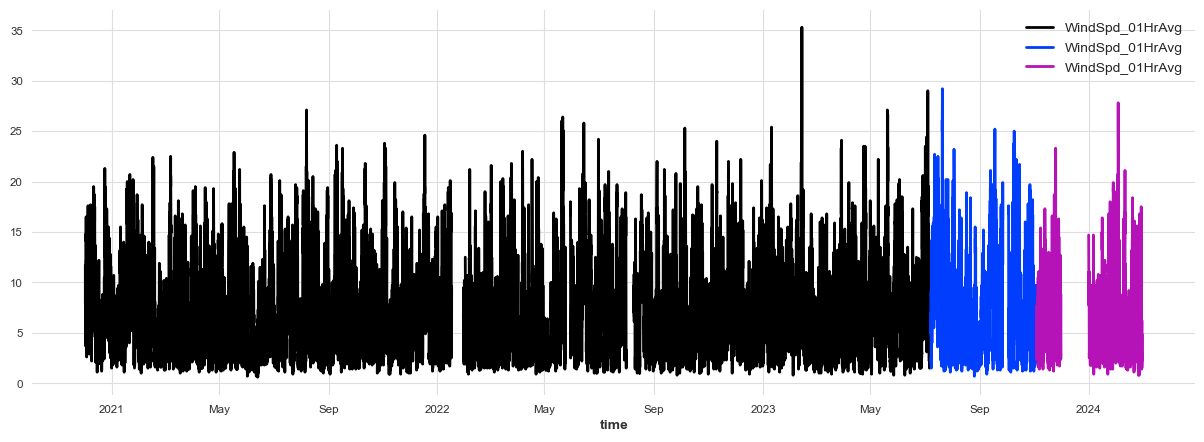

In [42]:
plt.figure(figsize=(15,5))
train_ts[target].plot()
valid_ts[target].plot()
test_ts[target].plot()

In [43]:
gaps_df = joined_ts.gaps()
gaps_df.to_csv('gaps.csv', index=True)